# Graph Neural Network Training Pipeline

Multi-Dataset Graph Classification with Noise-Robust Training

## 1. Setup and Dependencies

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:0000:01


In [2]:
import os
import gc
import sys
import torch
import pandas as pd
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import argparse
from sklearn.metrics import f1_score

In [3]:
helper_scripts_path = '/kaggle/input/d/leonardosandri/myhackatonhelperscripts/'

if os.path.exists(helper_scripts_path):
    # Add this path to the beginning of Python's search list
    sys.path.insert(0, helper_scripts_path)
    print(f"Successfully added '{helper_scripts_path}' to sys.path.")
    print(f"Contents of '{helper_scripts_path}': {os.listdir(helper_scripts_path)}") # Verify
else:
    print(f"WARNING: Helper scripts path not found: {helper_scripts_path}")
    print("Please ensure 'myhackathonhelperscripts' dataset is correctly added to the notebook.")

# Start import of utils modules
try:
    from preprocessor import MultiDatasetLoader
    from utils import set_seed
    # from conv import GINConv as OriginalRepoGINConv
    from models_EDandBatch_norm import GNN
    print("Successfully imported modules.")
except ImportError as e:
    print(f"ERROR importing module: {e}")
    print("Please check that the .py files exist directly under the helper_scripts_path and have no syntax errors.")
    # print("Current sys.path:", sys.path)

# Set the random seed
set_seed() # seed 777 default

Successfully added '/kaggle/input/d/leonardosandri/myhackatonhelperscripts/' to sys.path.
Contents of '/kaggle/input/d/leonardosandri/myhackatonhelperscripts/': ['models_edge_drop.py', 'zipthefolder.py', 'loadData.py', 'utils.py', 'models_layer_drop.py', 'models_EDandBatch_norm.py', 'models.py', 'conv.py', 'preprocessor.py', '__init__.py']
Successfully imported modules.


## 2. Data Preprocessing Functions


In [4]:
def add_zeros(data):
    data.x = torch.zeros(data.num_nodes, dtype=torch.long)
    return data

## 3. Training and Evaluation Functions

In [5]:
def train(data_loader, model, optimizer, criterion, device, save_checkpoints, checkpoint_path, current_epoch, scheduler=None, args=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, data in enumerate(tqdm(data_loader, desc="Iterating training graphs", unit="batch")):
        data = data.to(device)
        optimizer.zero_grad()
        
        try:
            output = model(data)
        except IndexError as e:
            print(f"Error in batch with {data.num_nodes} nodes, edge_max={data.edge_index.max()}")
            print(f"Batch info: x.shape={data.x.shape}, edge_index.shape={data.edge_index.shape}")
            raise e
            
        loss = criterion(output, data.y)
        loss.backward()

        # Numerical stability addition
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Step OneCycleLR scheduler after each batch
        if scheduler is not None and args.scheduler_type == 'OneCycleLR':
            scheduler.step()
            
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

    # Save checkpoints if required
    if save_checkpoints:
        checkpoint_file = f"{checkpoint_path}_epoch_{current_epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_file)
        print(f"Checkpoint saved at {checkpoint_file}")

    return total_loss / len(data_loader),  correct / total

In [6]:
# CELL 7 (Corrected)
def evaluate(data_loader, model, criterion, device, calculate_accuracy=False): # Added 'criterion' argument
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for data in tqdm(data_loader, desc="Iterating eval graphs", unit="batch"):
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            

            if calculate_accuracy:
                correct += (pred == data.y).sum().item()
                total += data.y.size(0)
                total_loss += criterion(output, data.y).item()
                true_labels.extend(data.y.cpu().numpy())
                
    if calculate_accuracy:
        print(f"Debug: predictions={len(predictions)}, true_labels={len(true_labels)}")  # Add this
        accuracy = correct / total
        # Calculate F1 scores
        f1_macro = f1_score(true_labels, predictions, average='macro')        
        return  total_loss / len(data_loader), accuracy, f1_macro
    return predictions

## 4. Utility Functions

In [7]:
def save_predictions(predictions, test_path):
    script_dir = os.getcwd() 
    submission_folder = os.path.join(script_dir, "submission")
    test_dir_name = os.path.basename(os.path.dirname(test_path))
    
    os.makedirs(submission_folder, exist_ok=True)
    
    output_csv_path = os.path.join(submission_folder, f"testset_{test_dir_name}.csv")
    
    test_graph_ids = list(range(len(predictions)))
    output_df = pd.DataFrame({
        "id": test_graph_ids,
        "pred": predictions
    })
    
    output_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

In [8]:
def plot_training_progress(train_losses, train_accuracies, val_losses, val_accuracies, output_dir):
    """
    Plot training and validation progress over epochs.
    
    Args:
        train_losses: List of training losses per epoch
        train_accuracies: List of training accuracies per epoch  
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch
        output_dir: Directory to save the plot
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 6))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color='blue', marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color='red', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color='green', marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    
    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_progress.png"))
    plt.show()
    plt.close()

## 5. Configuration and Arguments

In [9]:
def get_user_input(prompt, default=None, required=False, type_cast=str):

    while True:
        user_input = input(f"{prompt} [{default}]: ")
        
        if user_input == "" and required:
            print("This field is required. Please enter a value.")
            continue
        
        if user_input == "" and default is not None:
            return default
        
        if user_input == "" and not required:
            return None
        
        try:
            return type_cast(user_input)
        except ValueError:
            print(f"Invalid input. Please enter a valid {type_cast.__name__}.")

In [10]:
def get_arguments():
    """Set training configuration directly"""
    args = {
        # Dataset selection
        'dataset': 'B',  # Choose: A, B, C, D
        'train_mode': 1,  # 1=single dataset, 2=all datasets
        
        # Model config
        #'gnn': 'gin',  # gin, gin-virtual, gcn, gcn-virtual
        'num_layer': 2,
        'emb_dim': 128,
        'drop_ratio': 0.3,   # Dropout ratio
        'virtual_node': True, # True to use virtual node, False otherwise
        'residual': True,    # True to use residual connections, False otherwise
        'JK': "last",         # Jumping Knowledge: "last", "sum", "cat"
        'edge_drop_ratio' : 0.15,
        'batch_norm' : True,
        'graph_pooling': "mean", # "sum", "mean", "max", "attention", "set2set"
        
        # Training config
        'batch_size': 64,
        'epochs': 200,
        'baseline_mode': 3,  # 1=CE, 2=Noisy CE, 3 GCE
        'noise_prob': 0.2,
        'gce_q' : 0.9,
        'initial_lr' : 5e-3,

        # Best model criteria
        'best_model_criteria': 'f1',  # 'accuracy' or 'f1'

        # Lr scheduler config =================================================================================================================
        'use_scheduler' : True,
        'scheduler_type': 'ReduceLROnPlateau',  # Options: 'StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'ExponentialLR', 'OneCycleLR'

        # StepLR parameters
        'step_size': 30,      # Period of learning rate decay for StepLR
        'gamma': 0.5,         # Multiplicative factor of learning rate decay
        
        # ReduceLROnPlateau parameters
        'patience_lr': 12,    # Number of epochs with no improvement after which LR will be reduced
        'factor': 0.5,        # Factor by which the learning rate will be reduced
        'min_lr': 1e-7,       # Lower bound on the learning rate
        
        # CosineAnnealingLR parameters
        'T_max': 50,          # Maximum number of iterations for cosine annealing
        'eta_min': 1e-6,      # Minimum learning rate
        
        # ExponentialLR parameters
        'gamma_exp': 0.95,    # Multiplicative factor of learning rate decay for ExponentialLR
        
        # OneCycleLR parameters
        'max_lr': 1e-3,       # Upper learning rate boundary
        'pct_start': 0.3,     # Percentage of cycle spent increasing learning rate

        # =====================================================================================================================================
        
        # Early stopping config
        'early_stopping': True,  # Enable/disable early stopping
        'patience': 25,          # Number of epochs to wait without improvement
        
        # System config
        'device': 0,
        'num_checkpoints': 3,
    }
    return argparse.Namespace(**args)

In [11]:
def populate_args(args):
    print("Arguments received:")
    for key, value in vars(args).items():
        print(f"{key}: {value}")
args = get_arguments()
populate_args(args)

Arguments received:
dataset: B
train_mode: 1
num_layer: 2
emb_dim: 128
drop_ratio: 0.3
virtual_node: True
residual: True
JK: last
edge_drop_ratio: 0.15
batch_norm: True
graph_pooling: mean
batch_size: 64
epochs: 200
baseline_mode: 3
noise_prob: 0.2
gce_q: 0.9
initial_lr: 0.005
best_model_criteria: f1
use_scheduler: True
scheduler_type: ReduceLROnPlateau
step_size: 30
gamma: 0.5
patience_lr: 12
factor: 0.5
min_lr: 1e-07
T_max: 50
eta_min: 1e-06
gamma_exp: 0.95
max_lr: 0.001
pct_start: 0.3
early_stopping: True
patience: 25
device: 0
num_checkpoints: 3


## 6. Loss Function Definition

In [12]:
class NoisyCrossEntropyLoss(torch.nn.Module):
    def __init__(self, p_noisy):
        super().__init__()
        self.p = p_noisy
        self.ce = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        losses = self.ce(logits, targets)
        weights = (1 - self.p) + self.p * (1 - torch.nn.functional.one_hot(targets, num_classes=logits.size(1)).float().sum(dim=1))
        return (losses * weights).mean()

In [13]:
# CELL 12.1 (New Cell or append to existing cell 12)
class GeneralizedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, q=0.7):
        """
        Generalized Cross Entropy Loss.
        q is a hyperparameter, 0 < q <= 1.
        As q -> 0, GCE approaches standard CE.
        """
        super(GeneralizedCrossEntropyLoss, self).__init__()
        if not (0 < q <= 1):
            # While the limit q->0 is CE, for q=0 direct computation is 1/0.
            # The paper usually uses q > 0.
            raise ValueError("q should be in (0, 1]")
        self.q = q

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        # Select probabilities of the target class for each sample
        target_probs = probs[torch.arange(targets.size(0)), targets]

        # To prevent issues with target_probs being exactly 0,
        # especially if q is very small (though here q > 0).
        # However, 0^q is 0 for q > 0, so it should be fine.
        # For extra safety: target_probs = target_probs.clamp(min=1e-8)

        # Add numerical stability
        target_probs = target_probs.clamp(min=1e-7, max=1-1e-7)

        # GCE loss: (1 - p_t^q) / q
        loss = (1 - (target_probs ** self.q)) / self.q
        return loss.mean()

## 7. Model creation

### 7.1 Config section


In [14]:
print("=" * 60)
print("Enhanced GNN Training Pipeline")
print("=" * 60)

# Get configuration
args = get_arguments()

print("\nConfiguration:")
for key, value in vars(args).items():
    print(f"  {key}: {value}")

# Setup device
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

Enhanced GNN Training Pipeline

Configuration:
  dataset: B
  train_mode: 1
  num_layer: 2
  emb_dim: 128
  drop_ratio: 0.3
  virtual_node: True
  residual: True
  JK: last
  edge_drop_ratio: 0.15
  batch_norm: True
  graph_pooling: mean
  batch_size: 64
  epochs: 200
  baseline_mode: 3
  noise_prob: 0.2
  gce_q: 0.9
  initial_lr: 0.005
  best_model_criteria: f1
  use_scheduler: True
  scheduler_type: ReduceLROnPlateau
  step_size: 30
  gamma: 0.5
  patience_lr: 12
  factor: 0.5
  min_lr: 1e-07
  T_max: 50
  eta_min: 1e-06
  gamma_exp: 0.95
  max_lr: 0.001
  pct_start: 0.3
  early_stopping: True
  patience: 25
  device: 0
  num_checkpoints: 3

Using device: cuda:0


### 7.2 Data Loading

In [15]:
print("\n" + "="*40)
print("LOADING DATA")
print("="*40)

base_path = '/kaggle/input/deep-dataset-preprocessed/processed_data_separate'

# Prepare training/validation data based on mode
if args.train_mode == 1:
    # Single dataset mode
    dataset_name = args.dataset
    train_dataset = torch.load(f'{base_path}/{dataset_name}_train_graphs.pt', weights_only=False)
    train_dataset = [add_zeros(data) for data in train_dataset]
    
    val_dataset = torch.load(f'{base_path}/{dataset_name}_val_graphs.pt', weights_only=False)
    val_dataset = [add_zeros(data) for data in val_dataset]
    
    test_dataset = torch.load(f'{base_path}/{dataset_name}_test_graphs.pt', weights_only=False)
    test_dataset = [add_zeros(data) for data in test_dataset]
    print(f"Using single dataset: {dataset_name}")
else:
    # All datasets mode
    train_dataset = []
    val_dataset = []
    test_dataset = torch.load(f'{base_path}/{args.dataset}_test_graphs.pt', weights_only=False)  # Test on specified dataset
    
    for ds_name in ['A', 'B', 'C', 'D']:
        train_dataset.extend(torch.load(f'{base_path}/{ds_name}_train_graphs.pt', weights_only=False))
        val_dataset.extend(torch.load(f'{base_path}/{ds_name}_val_graphs.pt', weights_only=False))
    
    print("Using all datasets for training")

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)


LOADING DATA
Using single dataset: B
Train samples: 5040
Val samples: 560
Test samples: 1560


### 7.3 Model Setup

In [16]:

print("\n" + "="*40)
print("MODEL SETUP")
print("="*40)

# Initialize model
model = GNN(num_class=6, # Assuming 6 classes based on original notebook
            num_layer=args.num_layer,
            emb_dim=args.emb_dim,
            drop_ratio=args.drop_ratio,
            virtual_node=args.virtual_node,
            residual=args.residual,
            JK=args.JK,
            graph_pooling=args.graph_pooling,
            edge_drop_ratio = args.edge_drop_ratio,
            batch_norm=args.batch_norm
           )

model = model.to(device)

# Setup optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.initial_lr)

if args.baseline_mode == 2:
    criterion = NoisyCrossEntropyLoss(args.noise_prob)
    print(f"Using Noisy Cross Entropy Loss (p={args.noise_prob})")
elif args.baseline_mode == 3: # <--- ADD THIS BLOCK FOR GCE
    criterion = GeneralizedCrossEntropyLoss(q=args.gce_q)
    print(f"Using Generalized Cross Entropy (GCE) Loss (q={args.gce_q})")
else:
    criterion = torch.nn.CrossEntropyLoss()
    print("Using standard Cross Entropy Loss")

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Setup logging and checkpoints
exp_name = f"gin_dataset{args.dataset}_mode{args.train_mode}"
logs_dir = os.path.join("logs", exp_name)
checkpoints_dir = os.path.join("checkpoints", exp_name)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)

# Setup logging
log_file = os.path.join(logs_dir, "training.log")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

#best_model_path = os.path.join(checkpoints_dir, "best_model.pth")
best_model_path = '/kaggle/working/best_model.pth'


MODEL SETUP
Using Generalized Cross Entropy (GCE) Loss (q=0.9)
Model parameters: 203,400


## 8. Main training loop

### 8.1 Learning rate settings

In [17]:
# Learning Rate Scheduler Setup
print("\n" + "="*40)
print("SCHEDULER SETUP")
print("="*40)

# Update optimizer with initial learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=args.initial_lr)

scheduler = None
if args.use_scheduler:
    if args.scheduler_type == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=args.step_size, 
            gamma=args.gamma
        )
        print(f"Using StepLR scheduler: step_size={args.step_size}, gamma={args.gamma}")
        
    elif args.scheduler_type == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min',  # We want to reduce LR when validation loss stops decreasing
            factor=args.factor,
            patience=args.patience_lr,
            min_lr=args.min_lr,
        )
        print(f"Using ReduceLROnPlateau scheduler: factor={args.factor}, patience={args.patience_lr}, min_lr={args.min_lr}")
        
    elif args.scheduler_type == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=args.T_max,
            eta_min=args.eta_min
        )
        print(f"Using CosineAnnealingLR scheduler: T_max={args.T_max}, eta_min={args.eta_min}")
        
    elif args.scheduler_type == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma=args.gamma_exp
        )
        print(f"Using ExponentialLR scheduler: gamma={args.gamma_exp}")
        
    elif args.scheduler_type == 'OneCycleLR':
        # Calculate total steps for OneCycleLR
        total_steps = len(train_loader) * args.epochs
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=args.max_lr,
            total_steps=total_steps,
            pct_start=args.pct_start
        )
        print(f"Using OneCycleLR scheduler: max_lr={args.max_lr}, total_steps={total_steps}, pct_start={args.pct_start}")
        
    else:
        print(f"Unknown scheduler type: {args.scheduler_type}. No scheduler will be used.")
        args.use_scheduler = False
else:
    print("No learning rate scheduler will be used.")

print(f"Initial learning rate: {args.initial_lr}")


SCHEDULER SETUP
Using ReduceLROnPlateau scheduler: factor=0.5, patience=12, min_lr=1e-07
Initial learning rate: 0.005


### Training loop Call


In [18]:
print("\n" + "="*40)
print("TRAINING")
print("="*40)

best_val_metric = 0.0
metric_name = args.best_model_criteria.upper()
print(f"Using {metric_name} as best model criteria")

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
learning_rates = []
true_labels = []

# Early stopping variables
if args.early_stopping:
    epochs_without_improvement = 0
    print(f"Early stopping enabled with patience: {args.patience}")
else:
    print("Early stopping disabled")

# Calculate checkpoint intervals
if args.num_checkpoints > 1:
    checkpoint_intervals = [int((i + 1) * args.epochs / args.num_checkpoints) 
                          for i in range(args.num_checkpoints)]
else:
    checkpoint_intervals = [args.epochs]

for epoch in range(args.epochs):
    print(f"\nEpoch {epoch + 1}/{args.epochs}")
    print("-" * 30)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Training
    train_loss, train_acc = train(
        train_loader, model, optimizer, criterion, device,
        save_checkpoints=(epoch + 1 in checkpoint_intervals),
        checkpoint_path=os.path.join(checkpoints_dir, "checkpoint"),
        current_epoch=epoch,
        scheduler=scheduler,
        args=args
    )
    
    # Validation with F1 scores
    val_loss, val_acc, val_f1 = evaluate(
            val_loader, model, criterion, device, calculate_accuracy=True
    )

    # Select metric based on criteria
    current_metric = val_f1 if args.best_model_criteria == 'f1' else val_acc
    
    # Log results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"Val F1: {val_f1:.4f}")
    
    logging.info(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, LR={current_lr:.2e}, "
                f"F1={val_f1:.4f}")
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Save best model based on chosen criteria
    if current_metric > best_val_metric:
        best_val_metric = current_metric
        torch.save(model.state_dict(), best_model_path)
        print(f"★ New best {metric_name}! {metric_name}: {current_metric:.4f} "
                f"(Acc: {val_acc:.4f}, F1: {val_f1:.4f})")

        # Reset early stopping counter
        if args.early_stopping:
            epochs_without_improvement = 0

    else:
        # No improvement
        if args.early_stopping:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s)")
            
            # Check if we should stop early
            if epochs_without_improvement >= args.patience:
                print(f"\nEarly stopping triggered! No improvement for {args.patience} epochs.")
                print(f"Best {metric_name}: {best_val_metric:.4f}")
                break

    # Learning rate scheduler step
    if scheduler is not None:
        if args.scheduler_type == 'ReduceLROnPlateau':
            # ReduceLROnPlateau needs the metric to monitor
            scheduler.step(val_loss)
        elif args.scheduler_type == 'OneCycleLR':
            # OneCycleLR steps every batch, not every epoch
            # This is handled in the training function
            pass
        else:
            # Other schedulers step every epoch
            scheduler.step()
        
        # Check if learning rate changed
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr != current_lr:
            print(f"Learning rate changed: {current_lr:.2e} → {new_lr:.2e}")

    print(f"\nBest {metric_name}: {best_val_metric:.4f}")


TRAINING
Using F1 as best model criteria
Early stopping enabled with patience: 25

Epoch 1/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.20batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.8007, Train Acc: 0.2875
Val Loss: 0.7694, Val Acc: 0.3089
Learning Rate: 5.00e-03
Val F1: 0.1751
★ New best F1! F1: 0.1751 (Acc: 0.3089, F1: 0.1751)

Best F1: 0.1751

Epoch 2/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.80batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.7446, Train Acc: 0.3321
Val Loss: 0.7180, Val Acc: 0.3607
Learning Rate: 5.00e-03
Val F1: 0.2215
★ New best F1! F1: 0.2215 (Acc: 0.3607, F1: 0.2215)

Best F1: 0.2215

Epoch 3/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.40batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.7122, Train Acc: 0.3611
Val Loss: 0.7198, Val Acc: 0.3464
Learning Rate: 5.00e-03
Val F1: 0.1982
No improvement for 1 epoch(s)

Best F1: 0.2215

Epoch 4/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.26batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6860, Train Acc: 0.3831
Val Loss: 0.7173, Val Acc: 0.3554
Learning Rate: 5.00e-03
Val F1: 0.2247
★ New best F1! F1: 0.2247 (Acc: 0.3554, F1: 0.2247)

Best F1: 0.2247

Epoch 5/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6717, Train Acc: 0.3958
Val Loss: 0.6670, Val Acc: 0.3982
Learning Rate: 5.00e-03
Val F1: 0.2499
★ New best F1! F1: 0.2499 (Acc: 0.3982, F1: 0.2499)

Best F1: 0.2499

Epoch 6/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.73batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6453, Train Acc: 0.4224
Val Loss: 0.6193, Val Acc: 0.4446
Learning Rate: 5.00e-03
Val F1: 0.3235
★ New best F1! F1: 0.3235 (Acc: 0.4446, F1: 0.3235)

Best F1: 0.3235

Epoch 7/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.30batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6299, Train Acc: 0.4349
Val Loss: 0.6196, Val Acc: 0.4411
Learning Rate: 5.00e-03
Val F1: 0.3205
No improvement for 1 epoch(s)

Best F1: 0.3235

Epoch 8/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6206, Train Acc: 0.4450
Val Loss: 0.6077, Val Acc: 0.4536
Learning Rate: 5.00e-03
Val F1: 0.3144
No improvement for 2 epoch(s)

Best F1: 0.3235

Epoch 9/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.63batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6161, Train Acc: 0.4474
Val Loss: 0.6077, Val Acc: 0.4500
Learning Rate: 5.00e-03
Val F1: 0.3275
★ New best F1! F1: 0.3275 (Acc: 0.4500, F1: 0.3275)

Best F1: 0.3275

Epoch 10/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.44batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.6032, Train Acc: 0.4573
Val Loss: 0.6039, Val Acc: 0.4607
Learning Rate: 5.00e-03
Val F1: 0.3290
★ New best F1! F1: 0.3290 (Acc: 0.4607, F1: 0.3290)

Best F1: 0.3290

Epoch 11/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.13batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5814, Train Acc: 0.4802
Val Loss: 0.5715, Val Acc: 0.4929
Learning Rate: 5.00e-03
Val F1: 0.3926
★ New best F1! F1: 0.3926 (Acc: 0.4929, F1: 0.3926)

Best F1: 0.3926

Epoch 12/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.45batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5801, Train Acc: 0.4806
Val Loss: 0.7225, Val Acc: 0.3500
Learning Rate: 5.00e-03
Val F1: 0.2654
No improvement for 1 epoch(s)

Best F1: 0.3926

Epoch 13/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.91batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5708, Train Acc: 0.4881
Val Loss: 0.6021, Val Acc: 0.4607
Learning Rate: 5.00e-03
Val F1: 0.3507
No improvement for 2 epoch(s)

Best F1: 0.3926

Epoch 14/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.17batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5673, Train Acc: 0.4905
Val Loss: 0.5944, Val Acc: 0.4643
Learning Rate: 5.00e-03
Val F1: 0.3390
No improvement for 3 epoch(s)

Best F1: 0.3926

Epoch 15/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.34batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5545, Train Acc: 0.5038
Val Loss: 0.5951, Val Acc: 0.4589
Learning Rate: 5.00e-03
Val F1: 0.3418
No improvement for 4 epoch(s)

Best F1: 0.3926

Epoch 16/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.07batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5519, Train Acc: 0.5048
Val Loss: 0.6327, Val Acc: 0.4339
Learning Rate: 5.00e-03
Val F1: 0.3446
No improvement for 5 epoch(s)

Best F1: 0.3926

Epoch 17/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.37batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5526, Train Acc: 0.5056
Val Loss: 0.6419, Val Acc: 0.4232
Learning Rate: 5.00e-03
Val F1: 0.3314
No improvement for 6 epoch(s)

Best F1: 0.3926

Epoch 18/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.57batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5442, Train Acc: 0.5129
Val Loss: 0.5510, Val Acc: 0.5036
Learning Rate: 5.00e-03
Val F1: 0.3973
★ New best F1! F1: 0.3973 (Acc: 0.5036, F1: 0.3973)

Best F1: 0.3973

Epoch 19/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 37.98batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5469, Train Acc: 0.5097
Val Loss: 0.6225, Val Acc: 0.4429
Learning Rate: 5.00e-03
Val F1: 0.2989
No improvement for 1 epoch(s)

Best F1: 0.3973

Epoch 20/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.09batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5423, Train Acc: 0.5127
Val Loss: 0.5565, Val Acc: 0.5018
Learning Rate: 5.00e-03
Val F1: 0.3958
No improvement for 2 epoch(s)

Best F1: 0.3973

Epoch 21/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.99batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5374, Train Acc: 0.5169
Val Loss: 0.6505, Val Acc: 0.4125
Learning Rate: 5.00e-03
Val F1: 0.3359
No improvement for 3 epoch(s)

Best F1: 0.3973

Epoch 22/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5363, Train Acc: 0.5179
Val Loss: 0.5420, Val Acc: 0.5143
Learning Rate: 5.00e-03
Val F1: 0.4037
★ New best F1! F1: 0.4037 (Acc: 0.5143, F1: 0.4037)

Best F1: 0.4037

Epoch 23/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.75batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5418, Train Acc: 0.5135
Val Loss: 0.6090, Val Acc: 0.4500
Learning Rate: 5.00e-03
Val F1: 0.3690
No improvement for 1 epoch(s)

Best F1: 0.4037

Epoch 24/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.84batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5337, Train Acc: 0.5208
Val Loss: 0.5392, Val Acc: 0.5214
Learning Rate: 5.00e-03
Val F1: 0.4118
★ New best F1! F1: 0.4118 (Acc: 0.5214, F1: 0.4118)

Best F1: 0.4118

Epoch 25/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.93batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5281, Train Acc: 0.5248
Val Loss: 0.5932, Val Acc: 0.4643
Learning Rate: 5.00e-03
Val F1: 0.3925
No improvement for 1 epoch(s)

Best F1: 0.4118

Epoch 26/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.00batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5303, Train Acc: 0.5230
Val Loss: 0.5588, Val Acc: 0.5018
Learning Rate: 5.00e-03
Val F1: 0.3977
No improvement for 2 epoch(s)

Best F1: 0.4118

Epoch 27/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.93batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5315, Train Acc: 0.5228
Val Loss: 0.5711, Val Acc: 0.4893
Learning Rate: 5.00e-03
Val F1: 0.3937
No improvement for 3 epoch(s)

Best F1: 0.4118

Epoch 28/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.48batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5284, Train Acc: 0.5250
Val Loss: 0.6000, Val Acc: 0.4643
Learning Rate: 5.00e-03
Val F1: 0.3353
No improvement for 4 epoch(s)

Best F1: 0.4118

Epoch 29/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.91batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5230, Train Acc: 0.5300
Val Loss: 0.5250, Val Acc: 0.5321
Learning Rate: 5.00e-03
Val F1: 0.4358
★ New best F1! F1: 0.4358 (Acc: 0.5321, F1: 0.4358)

Best F1: 0.4358

Epoch 30/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.87batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5309, Train Acc: 0.5220
Val Loss: 0.5743, Val Acc: 0.4839
Learning Rate: 5.00e-03
Val F1: 0.3783
No improvement for 1 epoch(s)

Best F1: 0.4358

Epoch 31/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.75batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5222, Train Acc: 0.5317
Val Loss: 0.6133, Val Acc: 0.4554
Learning Rate: 5.00e-03
Val F1: 0.3423
No improvement for 2 epoch(s)

Best F1: 0.4358

Epoch 32/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.53batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5207, Train Acc: 0.5329
Val Loss: 0.5444, Val Acc: 0.5143
Learning Rate: 5.00e-03
Val F1: 0.4138
No improvement for 3 epoch(s)

Best F1: 0.4358

Epoch 33/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.78batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5157, Train Acc: 0.5369
Val Loss: 0.5419, Val Acc: 0.5196
Learning Rate: 5.00e-03
Val F1: 0.4385
★ New best F1! F1: 0.4385 (Acc: 0.5196, F1: 0.4385)

Best F1: 0.4385

Epoch 34/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.80batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5127, Train Acc: 0.5397
Val Loss: 0.5465, Val Acc: 0.5143
Learning Rate: 5.00e-03
Val F1: 0.4480
★ New best F1! F1: 0.4480 (Acc: 0.5143, F1: 0.4480)

Best F1: 0.4480

Epoch 35/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.74batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5216, Train Acc: 0.5315
Val Loss: 0.5354, Val Acc: 0.5161
Learning Rate: 5.00e-03
Val F1: 0.4306
No improvement for 1 epoch(s)

Best F1: 0.4480

Epoch 36/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.05batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5235, Train Acc: 0.5306
Val Loss: 0.5285, Val Acc: 0.5286
Learning Rate: 5.00e-03
Val F1: 0.4351
No improvement for 2 epoch(s)

Best F1: 0.4480

Epoch 37/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.27batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5160, Train Acc: 0.5349
Val Loss: 0.5884, Val Acc: 0.4643
Learning Rate: 5.00e-03
Val F1: 0.3791
No improvement for 3 epoch(s)

Best F1: 0.4480

Epoch 38/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.92batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5177, Train Acc: 0.5349
Val Loss: 0.5334, Val Acc: 0.5250
Learning Rate: 5.00e-03
Val F1: 0.4276
No improvement for 4 epoch(s)

Best F1: 0.4480

Epoch 39/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.43batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5136, Train Acc: 0.5381
Val Loss: 0.6271, Val Acc: 0.4321
Learning Rate: 5.00e-03
Val F1: 0.3839
No improvement for 5 epoch(s)

Best F1: 0.4480

Epoch 40/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.68batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5093, Train Acc: 0.5437
Val Loss: 0.5472, Val Acc: 0.5089
Learning Rate: 5.00e-03
Val F1: 0.4164
No improvement for 6 epoch(s)

Best F1: 0.4480

Epoch 41/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.71batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5104, Train Acc: 0.5413
Val Loss: 0.5587, Val Acc: 0.5000
Learning Rate: 5.00e-03
Val F1: 0.4147
No improvement for 7 epoch(s)

Best F1: 0.4480

Epoch 42/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.08batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5060, Train Acc: 0.5450
Val Loss: 0.6284, Val Acc: 0.4357
Learning Rate: 5.00e-03
Val F1: 0.3393
No improvement for 8 epoch(s)
Learning rate changed: 5.00e-03 → 2.50e-03

Best F1: 0.4480

Epoch 43/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.66batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.5025, Train Acc: 0.5476
Val Loss: 0.5022, Val Acc: 0.5518
Learning Rate: 2.50e-03
Val F1: 0.4694
★ New best F1! F1: 0.4694 (Acc: 0.5518, F1: 0.4694)

Best F1: 0.4694

Epoch 44/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4972, Train Acc: 0.5542
Val Loss: 0.4969, Val Acc: 0.5589
Learning Rate: 2.50e-03
Val F1: 0.4890
★ New best F1! F1: 0.4890 (Acc: 0.5589, F1: 0.4890)

Best F1: 0.4890

Epoch 45/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.67batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4903, Train Acc: 0.5599
Val Loss: 0.5187, Val Acc: 0.5357
Learning Rate: 2.50e-03
Val F1: 0.4525
No improvement for 1 epoch(s)

Best F1: 0.4890

Epoch 46/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.46batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4871, Train Acc: 0.5619
Val Loss: 0.5481, Val Acc: 0.5054
Learning Rate: 2.50e-03
Val F1: 0.4239
No improvement for 2 epoch(s)

Best F1: 0.4890

Epoch 47/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.01batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4854, Train Acc: 0.5641
Val Loss: 0.5158, Val Acc: 0.5393
Learning Rate: 2.50e-03
Val F1: 0.4585
No improvement for 3 epoch(s)

Best F1: 0.4890

Epoch 48/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.76batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4872, Train Acc: 0.5633
Val Loss: 0.5147, Val Acc: 0.5464
Learning Rate: 2.50e-03
Val F1: 0.4685
No improvement for 4 epoch(s)

Best F1: 0.4890

Epoch 49/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.19batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4829, Train Acc: 0.5673
Val Loss: 0.5125, Val Acc: 0.5429
Learning Rate: 2.50e-03
Val F1: 0.4725
No improvement for 5 epoch(s)

Best F1: 0.4890

Epoch 50/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.57batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4876, Train Acc: 0.5625
Val Loss: 0.5162, Val Acc: 0.5375
Learning Rate: 2.50e-03
Val F1: 0.4695
No improvement for 6 epoch(s)

Best F1: 0.4890

Epoch 51/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.91batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4830, Train Acc: 0.5657
Val Loss: 0.5211, Val Acc: 0.5339
Learning Rate: 2.50e-03
Val F1: 0.4413
No improvement for 7 epoch(s)

Best F1: 0.4890

Epoch 52/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.48batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4809, Train Acc: 0.5675
Val Loss: 0.5073, Val Acc: 0.5482
Learning Rate: 2.50e-03
Val F1: 0.4549
No improvement for 8 epoch(s)

Best F1: 0.4890

Epoch 53/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.05batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4752, Train Acc: 0.5738
Val Loss: 0.5116, Val Acc: 0.5446
Learning Rate: 2.50e-03
Val F1: 0.4779
No improvement for 9 epoch(s)

Best F1: 0.4890

Epoch 54/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.34batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4807, Train Acc: 0.5681
Val Loss: 0.5073, Val Acc: 0.5464
Learning Rate: 2.50e-03
Val F1: 0.4608
No improvement for 10 epoch(s)

Best F1: 0.4890

Epoch 55/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.51batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4789, Train Acc: 0.5708
Val Loss: 0.4987, Val Acc: 0.5554
Learning Rate: 2.50e-03
Val F1: 0.4764
No improvement for 11 epoch(s)

Best F1: 0.4890

Epoch 56/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.56batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4834, Train Acc: 0.5651
Val Loss: 0.5158, Val Acc: 0.5357
Learning Rate: 2.50e-03
Val F1: 0.4526
No improvement for 12 epoch(s)

Best F1: 0.4890

Epoch 57/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.87batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4830, Train Acc: 0.5661
Val Loss: 0.5104, Val Acc: 0.5393
Learning Rate: 2.50e-03
Val F1: 0.4608
No improvement for 13 epoch(s)
Learning rate changed: 2.50e-03 → 1.25e-03

Best F1: 0.4890

Epoch 58/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.44batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4741, Train Acc: 0.5734
Val Loss: 0.4853, Val Acc: 0.5679
Learning Rate: 1.25e-03
Val F1: 0.4928
★ New best F1! F1: 0.4928 (Acc: 0.5679, F1: 0.4928)

Best F1: 0.4928

Epoch 59/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.44batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4679, Train Acc: 0.5800
Val Loss: 0.4982, Val Acc: 0.5518
Learning Rate: 1.25e-03
Val F1: 0.4807
No improvement for 1 epoch(s)

Best F1: 0.4928

Epoch 60/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.46batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4655, Train Acc: 0.5810
Val Loss: 0.4872, Val Acc: 0.5643
Learning Rate: 1.25e-03
Val F1: 0.4846
No improvement for 2 epoch(s)

Best F1: 0.4928

Epoch 61/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.06batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4635, Train Acc: 0.5843
Val Loss: 0.5092, Val Acc: 0.5464
Learning Rate: 1.25e-03
Val F1: 0.4615
No improvement for 3 epoch(s)

Best F1: 0.4928

Epoch 62/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.19batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4658, Train Acc: 0.5806
Val Loss: 0.5012, Val Acc: 0.5464
Learning Rate: 1.25e-03
Val F1: 0.4737
No improvement for 4 epoch(s)

Best F1: 0.4928

Epoch 63/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.58batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4644, Train Acc: 0.5831
Val Loss: 0.5030, Val Acc: 0.5464
Learning Rate: 1.25e-03
Val F1: 0.4761
No improvement for 5 epoch(s)

Best F1: 0.4928

Epoch 64/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.67batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4630, Train Acc: 0.5861
Val Loss: 0.4877, Val Acc: 0.5625
Learning Rate: 1.25e-03
Val F1: 0.4954
★ New best F1! F1: 0.4954 (Acc: 0.5625, F1: 0.4954)

Best F1: 0.4954

Epoch 65/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.15batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4603, Train Acc: 0.5865
Val Loss: 0.4873, Val Acc: 0.5643
Learning Rate: 1.25e-03
Val F1: 0.4858
No improvement for 1 epoch(s)

Best F1: 0.4954

Epoch 66/200
------------------------------


Iterating training graphs: 100%|██████████| 79/79 [00:03<00:00, 24.42batch/s]


Checkpoint saved at checkpoints/gin_datasetB_mode1/checkpoint_epoch_66.pth


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.46batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4623, Train Acc: 0.5851
Val Loss: 0.4923, Val Acc: 0.5607
Learning Rate: 1.25e-03
Val F1: 0.4927
No improvement for 2 epoch(s)

Best F1: 0.4954

Epoch 67/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.59batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4609, Train Acc: 0.5865
Val Loss: 0.4822, Val Acc: 0.5732
Learning Rate: 1.25e-03
Val F1: 0.4992
★ New best F1! F1: 0.4992 (Acc: 0.5732, F1: 0.4992)

Best F1: 0.4992

Epoch 68/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 41.04batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4618, Train Acc: 0.5861
Val Loss: 0.4949, Val Acc: 0.5571
Learning Rate: 1.25e-03
Val F1: 0.4897
No improvement for 1 epoch(s)

Best F1: 0.4992

Epoch 69/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.77batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4621, Train Acc: 0.5851
Val Loss: 0.4939, Val Acc: 0.5554
Learning Rate: 1.25e-03
Val F1: 0.4778
No improvement for 2 epoch(s)

Best F1: 0.4992

Epoch 70/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.53batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4606, Train Acc: 0.5873
Val Loss: 0.5060, Val Acc: 0.5464
Learning Rate: 1.25e-03
Val F1: 0.4689
No improvement for 3 epoch(s)

Best F1: 0.4992

Epoch 71/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.56batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4577, Train Acc: 0.5885
Val Loss: 0.4923, Val Acc: 0.5571
Learning Rate: 1.25e-03
Val F1: 0.4860
No improvement for 4 epoch(s)

Best F1: 0.4992

Epoch 72/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.65batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4617, Train Acc: 0.5851
Val Loss: 0.5023, Val Acc: 0.5464
Learning Rate: 1.25e-03
Val F1: 0.4739
No improvement for 5 epoch(s)

Best F1: 0.4992

Epoch 73/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.48batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4585, Train Acc: 0.5881
Val Loss: 0.4853, Val Acc: 0.5661
Learning Rate: 1.25e-03
Val F1: 0.4942
No improvement for 6 epoch(s)

Best F1: 0.4992

Epoch 74/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.61batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4587, Train Acc: 0.5865
Val Loss: 0.4969, Val Acc: 0.5554
Learning Rate: 1.25e-03
Val F1: 0.4782
No improvement for 7 epoch(s)

Best F1: 0.4992

Epoch 75/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.91batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4576, Train Acc: 0.5885
Val Loss: 0.5085, Val Acc: 0.5446
Learning Rate: 1.25e-03
Val F1: 0.4538
No improvement for 8 epoch(s)

Best F1: 0.4992

Epoch 76/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.31batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4584, Train Acc: 0.5879
Val Loss: 0.4854, Val Acc: 0.5696
Learning Rate: 1.25e-03
Val F1: 0.4994
★ New best F1! F1: 0.4994 (Acc: 0.5696, F1: 0.4994)

Best F1: 0.4994

Epoch 77/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.09batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4569, Train Acc: 0.5895
Val Loss: 0.4915, Val Acc: 0.5625
Learning Rate: 1.25e-03
Val F1: 0.5024
★ New best F1! F1: 0.5024 (Acc: 0.5625, F1: 0.5024)

Best F1: 0.5024

Epoch 78/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.13batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4560, Train Acc: 0.5903
Val Loss: 0.4891, Val Acc: 0.5625
Learning Rate: 1.25e-03
Val F1: 0.4915
No improvement for 1 epoch(s)

Best F1: 0.5024

Epoch 79/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.41batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4569, Train Acc: 0.5897
Val Loss: 0.5029, Val Acc: 0.5518
Learning Rate: 1.25e-03
Val F1: 0.4906
No improvement for 2 epoch(s)

Best F1: 0.5024

Epoch 80/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4559, Train Acc: 0.5901
Val Loss: 0.4960, Val Acc: 0.5571
Learning Rate: 1.25e-03
Val F1: 0.4942
No improvement for 3 epoch(s)
Learning rate changed: 1.25e-03 → 6.25e-04

Best F1: 0.5024

Epoch 81/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.16batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4514, Train Acc: 0.5938
Val Loss: 0.4856, Val Acc: 0.5661
Learning Rate: 6.25e-04
Val F1: 0.4968
No improvement for 4 epoch(s)

Best F1: 0.5024

Epoch 82/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.60batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4520, Train Acc: 0.5933
Val Loss: 0.4859, Val Acc: 0.5661
Learning Rate: 6.25e-04
Val F1: 0.4971
No improvement for 5 epoch(s)

Best F1: 0.5024

Epoch 83/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.79batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4490, Train Acc: 0.5964
Val Loss: 0.4900, Val Acc: 0.5625
Learning Rate: 6.25e-04
Val F1: 0.4957
No improvement for 6 epoch(s)

Best F1: 0.5024

Epoch 84/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.33batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4526, Train Acc: 0.5929
Val Loss: 0.4839, Val Acc: 0.5679
Learning Rate: 6.25e-04
Val F1: 0.4974
No improvement for 7 epoch(s)

Best F1: 0.5024

Epoch 85/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.68batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4497, Train Acc: 0.5962
Val Loss: 0.4943, Val Acc: 0.5554
Learning Rate: 6.25e-04
Val F1: 0.4925
No improvement for 8 epoch(s)

Best F1: 0.5024

Epoch 86/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.38batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4491, Train Acc: 0.5968
Val Loss: 0.4855, Val Acc: 0.5661
Learning Rate: 6.25e-04
Val F1: 0.4944
No improvement for 9 epoch(s)

Best F1: 0.5024

Epoch 87/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.04batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4480, Train Acc: 0.5984
Val Loss: 0.4953, Val Acc: 0.5554
Learning Rate: 6.25e-04
Val F1: 0.4806
No improvement for 10 epoch(s)

Best F1: 0.5024

Epoch 88/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.89batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4497, Train Acc: 0.5968
Val Loss: 0.4838, Val Acc: 0.5679
Learning Rate: 6.25e-04
Val F1: 0.4985
No improvement for 11 epoch(s)

Best F1: 0.5024

Epoch 89/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 38.89batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4482, Train Acc: 0.5972
Val Loss: 0.4895, Val Acc: 0.5607
Learning Rate: 6.25e-04
Val F1: 0.4887
No improvement for 12 epoch(s)

Best F1: 0.5024

Epoch 90/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.57batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4486, Train Acc: 0.5962
Val Loss: 0.4903, Val Acc: 0.5589
Learning Rate: 6.25e-04
Val F1: 0.4910
No improvement for 13 epoch(s)

Best F1: 0.5024

Epoch 91/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.24batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4480, Train Acc: 0.5968
Val Loss: 0.4902, Val Acc: 0.5607
Learning Rate: 6.25e-04
Val F1: 0.4874
No improvement for 14 epoch(s)

Best F1: 0.5024

Epoch 92/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.06batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4484, Train Acc: 0.5978
Val Loss: 0.4881, Val Acc: 0.5661
Learning Rate: 6.25e-04
Val F1: 0.4964
No improvement for 15 epoch(s)

Best F1: 0.5024

Epoch 93/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.06batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4496, Train Acc: 0.5958
Val Loss: 0.4870, Val Acc: 0.5643
Learning Rate: 6.25e-04
Val F1: 0.4959
No improvement for 16 epoch(s)
Learning rate changed: 6.25e-04 → 3.13e-04

Best F1: 0.5024

Epoch 94/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.45batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4460, Train Acc: 0.5992
Val Loss: 0.4860, Val Acc: 0.5661
Learning Rate: 3.13e-04
Val F1: 0.4973
No improvement for 17 epoch(s)

Best F1: 0.5024

Epoch 95/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 38.56batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4459, Train Acc: 0.5998
Val Loss: 0.4873, Val Acc: 0.5643
Learning Rate: 3.13e-04
Val F1: 0.4932
No improvement for 18 epoch(s)

Best F1: 0.5024

Epoch 96/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.32batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4456, Train Acc: 0.5996
Val Loss: 0.4853, Val Acc: 0.5679
Learning Rate: 3.13e-04
Val F1: 0.4981
No improvement for 19 epoch(s)

Best F1: 0.5024

Epoch 97/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.13batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4432, Train Acc: 0.6022
Val Loss: 0.4846, Val Acc: 0.5679
Learning Rate: 3.13e-04
Val F1: 0.4960
No improvement for 20 epoch(s)

Best F1: 0.5024

Epoch 98/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.67batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4443, Train Acc: 0.6012
Val Loss: 0.4896, Val Acc: 0.5661
Learning Rate: 3.13e-04
Val F1: 0.4971
No improvement for 21 epoch(s)

Best F1: 0.5024

Epoch 99/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.49batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4453, Train Acc: 0.5992
Val Loss: 0.4903, Val Acc: 0.5625
Learning Rate: 3.13e-04
Val F1: 0.4922
No improvement for 22 epoch(s)

Best F1: 0.5024

Epoch 100/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.56batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4454, Train Acc: 0.5998
Val Loss: 0.4830, Val Acc: 0.5696
Learning Rate: 3.13e-04
Val F1: 0.4998
No improvement for 23 epoch(s)

Best F1: 0.5024

Epoch 101/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 39.02batch/s]


Debug: predictions=560, true_labels=560
Train Loss: 0.4448, Train Acc: 0.6006
Val Loss: 0.4898, Val Acc: 0.5607
Learning Rate: 3.13e-04
Val F1: 0.4872
No improvement for 24 epoch(s)

Best F1: 0.5024

Epoch 102/200
------------------------------


Iterating eval graphs: 100%|██████████| 9/9 [00:00<00:00, 40.29batch/s]

Debug: predictions=560, true_labels=560
Train Loss: 0.4449, Train Acc: 0.6008
Val Loss: 0.4882, Val Acc: 0.5643
Learning Rate: 3.13e-04
Val F1: 0.4908
No improvement for 25 epoch(s)

Early stopping triggered! No improvement for 25 epochs.
Best F1: 0.5024


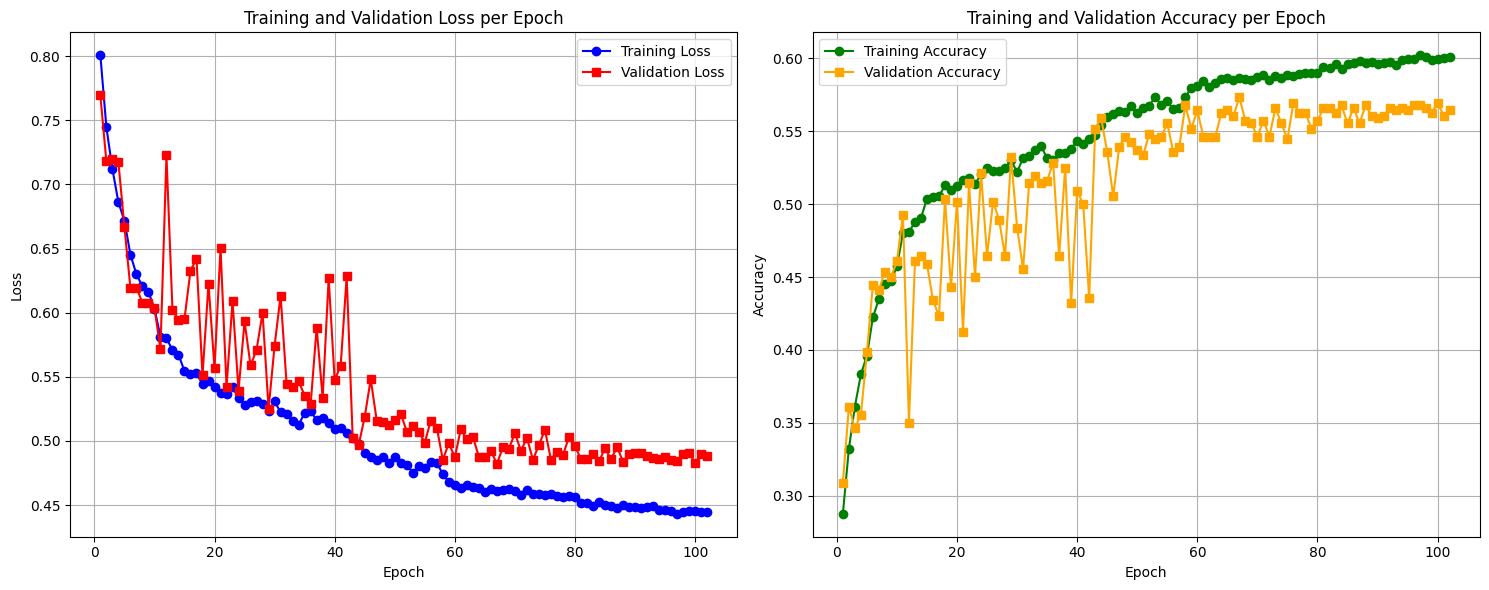

In [19]:
# Plot training progress
plot_training_progress(train_losses, train_accuracies, val_losses, val_accuracies, logs_dir)

### 7.5 Testing and predictions

In [20]:
print("\n" + "="*40)
print("TESTING")
print("="*40)

# Load best model and make predictions
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

predictions = evaluate(test_loader, model, criterion, device, calculate_accuracy=False)

# Save predictions
save_predictions(predictions, args.dataset)

# Cleanup for memory
del train_dataset, val_dataset, test_dataset
del train_loader, val_loader, test_loader
gc.collect()

print("\n" + "="*60)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Best {metric_name}: {best_val_metric:.4f}")
print(f"Predictions saved for dataset {args.dataset}")
print(f"Logs and plots saved in: {logs_dir}")


TESTING
Loaded best model from: /kaggle/working/best_model.pth


Iterating eval graphs: 100%|██████████| 25/25 [00:00<00:00, 37.35batch/s]


Predictions saved to /kaggle/working/submission/testset_.csv

TRAINING COMPLETED SUCCESSFULLY!
Best F1: 0.5024
Predictions saved for dataset B
Logs and plots saved in: logs/gin_datasetB_mode1
